In [2]:
import os
import pandas as pd
import wfdb

# путь к папке с PTB-XL
data_root = "/Users/elizaveta/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
db_csv = os.path.join(data_root, "ptbxl_database.csv")

# читаем CSV с метаданными
df = pd.read_csv(db_csv, index_col="ecg_id")

In [3]:
# === Функции для загрузки данных и предобработки ===
def load_ptbxl_lr(ecg_id):
    """Загрузка LR (100Hz) сигнала"""
    row = df.loc[ecg_id]
    fn = os.path.join(data_root, row["filename_lr"])
    sig, meta = wfdb.rdsamp(fn)
    sig = sig.T  # (12, samples)
    return sig, meta

from scipy.signal import resample
from biosppy.signals.tools import filter_signal
import numpy as np

def apply_filter(signal, filter_bandwidth, fs=100):
    order = int(0.3 * fs)
    s, _, _ = filter_signal(signal=signal, ftype='FIR', band='bandpass',
                            order=order, frequency=filter_bandwidth,
                            sampling_rate=fs)
    return s

def scale_minus1_1(seq, eps=1e-8):
    minv = np.min(seq, axis=1, keepdims=True)
    maxv = np.max(seq, axis=1, keepdims=True)
    return 2 * (seq - minv) / (maxv - minv + eps) - 1

def preprocess_one(sig, orig_fs, target_fs=100, duration_sec=5, band=[0.5,40]):
    """Сигнал на входе: (12, samples). Возвращает (12, target_fs*duration_sec)"""
    channels, length = sig.shape
    assert channels == 12, "Ожидается 12 каналов"
    
    n_take = int(duration_sec * orig_fs)
    sig_cut = sig[:, :n_take]
    
    n_target = int(duration_sec * target_fs)
    sig_rs = resample(sig_cut, n_target, axis=1)
    
    sig_f = apply_filter(sig_rs, filter_bandwidth=[0.05, 47], fs=target_fs)
    sig_s = scale_minus1_1(sig_f)
    
    assert sig_s.shape == (12, n_target)
    assert np.isfinite(sig_s).all()
    
    return sig_s


In [4]:
import torch
from transformers import AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

hubert_ecg = AutoModel.from_pretrained("Edoardo-BS/hubert-ecg-base", trust_remote_code=True).to(device)
hubert_ecg.eval()

/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: mps


HuBERTECG(
  (feature_extractor): HubertFeatureEncoder(
    (conv_layers): ModuleList(
      (0): HubertGroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(4,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-2): 2 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (3-4): 2 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): HubertFeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): HubertEncoder(
    (pos_conv_embed): HubertPositionalConvEmbedding(
      (conv): Parame

In [5]:
ecg_id = df.index[0]
sig, meta = load_ptbxl_lr(ecg_id)
sig_pre = preprocess_one(sig, orig_fs=int(meta.get("fs", 100)))

lead_index = 1  # II отведение
lead_signal = sig_pre[lead_index]

x = torch.tensor(lead_signal, dtype=torch.float32)[None, :].to(device)  # (1, 500)
with torch.no_grad():
    output = hubert_ecg(input_values=x)
    emb = output.last_hidden_state.mean(dim=1).cpu().numpy().flatten()

print("Embedding shape:", emb.shape)
print("First 10 values:", emb[:10])


Embedding shape: (768,)
First 10 values: [ 0.5368746   0.6124233  -0.33293778  0.13614514 -0.31500986  1.518364
  1.4277295  -0.734893    0.13093613  0.3714349 ]


In [7]:
import tqdm
import numpy as np
import os

# Новая папка для эмбеддингов всех 12 отведений
save_dir = "/Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47"
os.makedirs(save_dir, exist_ok=True)

n_samples = len(df)   # можно уменьшить для теста, например n_samples = 100
chunk_size = 200      # батч по 200 сигналов

for start in range(0, n_samples, chunk_size):
    end = min(start + chunk_size, n_samples)
    actual_chunk_size = end - start
    # создаём массив (N, 12, 768)
    embeddings_chunk = np.zeros((actual_chunk_size, 12, 768), dtype=np.float32)

    for i, ecg_id in enumerate(tqdm.tqdm(df.index[start:end], desc=f"Processing {start}-{end}")):
        # Загружаем сигнал и предобрабатываем
        sig, meta = load_ptbxl_lr(ecg_id)
        sig_pre = preprocess_one(sig, orig_fs=int(meta.get("fs", 100)))
        
        lead_embeddings = []
        for lead_index in range(12):
            x = torch.tensor(sig_pre[lead_index], dtype=torch.float32)[None, :].to(device)
            with torch.no_grad():
                output = hubert_ecg(input_values=x)
                emb = output.last_hidden_state.mean(dim=1).cpu().numpy().flatten()
            lead_embeddings.append(emb)
        
        embeddings_chunk[i] = np.stack(lead_embeddings)

    # Сохраняем батч
    chunk_file = os.path.join(save_dir, f"embeddings_12leads_{start}_{end}.npy")
    np.save(chunk_file, embeddings_chunk)
    print(f"Saved {chunk_file}")

print("✅ Все эмбеддинги по 12 отведениям успешно построены и сохранены в:", save_dir)


Processing 0-200: 100%|██████████| 200/200 [00:32<00:00,  6.24it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_0_200.npy


Processing 200-400: 100%|██████████| 200/200 [00:34<00:00,  5.86it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_200_400.npy


Processing 400-600: 100%|██████████| 200/200 [00:36<00:00,  5.53it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_400_600.npy


Processing 600-800: 100%|██████████| 200/200 [00:35<00:00,  5.56it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_600_800.npy


Processing 800-1000: 100%|██████████| 200/200 [00:40<00:00,  4.99it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_800_1000.npy


Processing 1000-1200: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_1000_1200.npy


Processing 1200-1400: 100%|██████████| 200/200 [00:35<00:00,  5.57it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_1200_1400.npy


Processing 1400-1600: 100%|██████████| 200/200 [00:37<00:00,  5.37it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_1400_1600.npy


Processing 1600-1800: 100%|██████████| 200/200 [00:34<00:00,  5.83it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_1600_1800.npy


Processing 1800-2000: 100%|██████████| 200/200 [00:34<00:00,  5.81it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_1800_2000.npy


Processing 2000-2200: 100%|██████████| 200/200 [00:39<00:00,  5.04it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_2000_2200.npy


Processing 2200-2400: 100%|██████████| 200/200 [00:38<00:00,  5.21it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_2200_2400.npy


Processing 2400-2600: 100%|██████████| 200/200 [00:40<00:00,  4.96it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_2400_2600.npy


Processing 2600-2800: 100%|██████████| 200/200 [00:40<00:00,  4.96it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_2600_2800.npy


Processing 2800-3000: 100%|██████████| 200/200 [00:37<00:00,  5.34it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_2800_3000.npy


Processing 3000-3200: 100%|██████████| 200/200 [00:37<00:00,  5.27it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_3000_3200.npy


Processing 3200-3400: 100%|██████████| 200/200 [00:36<00:00,  5.48it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_3200_3400.npy


Processing 3400-3600: 100%|██████████| 200/200 [00:38<00:00,  5.17it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_3400_3600.npy


Processing 3600-3800: 100%|██████████| 200/200 [00:39<00:00,  5.01it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_3600_3800.npy


Processing 3800-4000: 100%|██████████| 200/200 [00:35<00:00,  5.67it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_3800_4000.npy


Processing 4000-4200: 100%|██████████| 200/200 [00:40<00:00,  4.98it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_4000_4200.npy


Processing 4200-4400: 100%|██████████| 200/200 [00:39<00:00,  5.13it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_4200_4400.npy


Processing 4400-4600: 100%|██████████| 200/200 [00:37<00:00,  5.37it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_4400_4600.npy


Processing 4600-4800: 100%|██████████| 200/200 [00:37<00:00,  5.31it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_4600_4800.npy


Processing 4800-5000: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_4800_5000.npy


Processing 5000-5200: 100%|██████████| 200/200 [00:40<00:00,  4.96it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_5000_5200.npy


Processing 5200-5400: 100%|██████████| 200/200 [00:38<00:00,  5.22it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_5200_5400.npy


Processing 5400-5600: 100%|██████████| 200/200 [00:39<00:00,  5.07it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_5400_5600.npy


Processing 5600-5800: 100%|██████████| 200/200 [00:38<00:00,  5.16it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_5600_5800.npy


Processing 5800-6000: 100%|██████████| 200/200 [00:38<00:00,  5.18it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_5800_6000.npy


Processing 6000-6200: 100%|██████████| 200/200 [00:40<00:00,  4.97it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_6000_6200.npy


Processing 6200-6400: 100%|██████████| 200/200 [00:39<00:00,  5.11it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_6200_6400.npy


Processing 6400-6600: 100%|██████████| 200/200 [00:39<00:00,  5.09it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_6400_6600.npy


Processing 6600-6800: 100%|██████████| 200/200 [00:39<00:00,  5.00it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_6600_6800.npy


Processing 6800-7000: 100%|██████████| 200/200 [00:38<00:00,  5.14it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_6800_7000.npy


Processing 7000-7200: 100%|██████████| 200/200 [00:38<00:00,  5.22it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_7000_7200.npy


Processing 7200-7400: 100%|██████████| 200/200 [00:35<00:00,  5.57it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_7200_7400.npy


Processing 7400-7600: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_7400_7600.npy


Processing 7600-7800: 100%|██████████| 200/200 [00:35<00:00,  5.62it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_7600_7800.npy


Processing 7800-8000: 100%|██████████| 200/200 [00:39<00:00,  5.00it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_7800_8000.npy


Processing 8000-8200: 100%|██████████| 200/200 [00:40<00:00,  4.92it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_8000_8200.npy


Processing 8200-8400: 100%|██████████| 200/200 [00:39<00:00,  5.04it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_8200_8400.npy


Processing 8400-8600: 100%|██████████| 200/200 [00:40<00:00,  5.00it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_8400_8600.npy


Processing 8600-8800: 100%|██████████| 200/200 [00:35<00:00,  5.65it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_8600_8800.npy


Processing 8800-9000: 100%|██████████| 200/200 [00:36<00:00,  5.45it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_8800_9000.npy


Processing 9000-9200: 100%|██████████| 200/200 [00:34<00:00,  5.72it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_9000_9200.npy


Processing 9200-9400: 100%|██████████| 200/200 [00:34<00:00,  5.72it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_9200_9400.npy


Processing 9400-9600: 100%|██████████| 200/200 [00:36<00:00,  5.46it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_9400_9600.npy


Processing 9600-9800: 100%|██████████| 200/200 [00:35<00:00,  5.67it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_9600_9800.npy


Processing 9800-10000: 100%|██████████| 200/200 [00:34<00:00,  5.75it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_9800_10000.npy


Processing 10000-10200: 100%|██████████| 200/200 [00:34<00:00,  5.85it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_10000_10200.npy


Processing 10200-10400: 100%|██████████| 200/200 [00:34<00:00,  5.75it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_10200_10400.npy


Processing 10400-10600: 100%|██████████| 200/200 [00:35<00:00,  5.66it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_10400_10600.npy


Processing 10600-10800: 100%|██████████| 200/200 [00:36<00:00,  5.51it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_10600_10800.npy


Processing 10800-11000: 100%|██████████| 200/200 [00:36<00:00,  5.45it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_10800_11000.npy


Processing 11000-11200: 100%|██████████| 200/200 [00:36<00:00,  5.46it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_11000_11200.npy


Processing 11200-11400: 100%|██████████| 200/200 [00:34<00:00,  5.72it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_11200_11400.npy


Processing 11400-11600: 100%|██████████| 200/200 [00:35<00:00,  5.62it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_11400_11600.npy


Processing 11600-11800: 100%|██████████| 200/200 [00:34<00:00,  5.84it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_11600_11800.npy


Processing 11800-12000: 100%|██████████| 200/200 [00:35<00:00,  5.67it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_11800_12000.npy


Processing 12000-12200: 100%|██████████| 200/200 [00:34<00:00,  5.77it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_12000_12200.npy


Processing 12200-12400: 100%|██████████| 200/200 [00:37<00:00,  5.37it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_12200_12400.npy


Processing 12400-12600: 100%|██████████| 200/200 [00:36<00:00,  5.44it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_12400_12600.npy


Processing 12600-12800: 100%|██████████| 200/200 [00:34<00:00,  5.72it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_12600_12800.npy


Processing 12800-13000: 100%|██████████| 200/200 [00:36<00:00,  5.55it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_12800_13000.npy


Processing 13000-13200: 100%|██████████| 200/200 [00:38<00:00,  5.20it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_13000_13200.npy


Processing 13200-13400: 100%|██████████| 200/200 [00:38<00:00,  5.20it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_13200_13400.npy


Processing 13400-13600: 100%|██████████| 200/200 [00:38<00:00,  5.22it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_13400_13600.npy


Processing 13600-13800: 100%|██████████| 200/200 [00:37<00:00,  5.35it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_13600_13800.npy


Processing 13800-14000: 100%|██████████| 200/200 [00:35<00:00,  5.56it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_13800_14000.npy


Processing 14000-14200: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_14000_14200.npy


Processing 14200-14400: 100%|██████████| 200/200 [00:36<00:00,  5.50it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_14200_14400.npy


Processing 14400-14600: 100%|██████████| 200/200 [00:36<00:00,  5.47it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_14400_14600.npy


Processing 14600-14800: 100%|██████████| 200/200 [04:50<00:00,  1.45s/it]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_14600_14800.npy


Processing 14800-15000: 100%|██████████| 200/200 [00:36<00:00,  5.45it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_14800_15000.npy


Processing 15000-15200: 100%|██████████| 200/200 [00:39<00:00,  5.05it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_15000_15200.npy


Processing 15200-15400: 100%|██████████| 200/200 [00:40<00:00,  4.96it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_15200_15400.npy


Processing 15400-15600: 100%|██████████| 200/200 [00:39<00:00,  5.06it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_15400_15600.npy


Processing 15600-15800: 100%|██████████| 200/200 [00:35<00:00,  5.56it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_15600_15800.npy


Processing 15800-16000: 100%|██████████| 200/200 [00:36<00:00,  5.50it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_15800_16000.npy


Processing 16000-16200: 100%|██████████| 200/200 [00:39<00:00,  5.05it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_16000_16200.npy


Processing 16200-16400: 100%|██████████| 200/200 [00:36<00:00,  5.44it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_16200_16400.npy


Processing 16400-16600: 100%|██████████| 200/200 [00:34<00:00,  5.87it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_16400_16600.npy


Processing 16600-16800: 100%|██████████| 200/200 [00:32<00:00,  6.07it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_16600_16800.npy


Processing 16800-17000: 100%|██████████| 200/200 [00:35<00:00,  5.61it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_16800_17000.npy


Processing 17000-17200: 100%|██████████| 200/200 [00:33<00:00,  6.01it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_17000_17200.npy


Processing 17200-17400: 100%|██████████| 200/200 [00:34<00:00,  5.75it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_17200_17400.npy


Processing 17400-17600: 100%|██████████| 200/200 [00:34<00:00,  5.72it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_17400_17600.npy


Processing 17600-17800: 100%|██████████| 200/200 [00:34<00:00,  5.77it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_17600_17800.npy


Processing 17800-18000: 100%|██████████| 200/200 [00:34<00:00,  5.79it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_17800_18000.npy


Processing 18000-18200: 100%|██████████| 200/200 [00:34<00:00,  5.74it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_18000_18200.npy


Processing 18200-18400: 100%|██████████| 200/200 [00:34<00:00,  5.84it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_18200_18400.npy


Processing 18400-18600: 100%|██████████| 200/200 [00:35<00:00,  5.71it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_18400_18600.npy


Processing 18600-18800: 100%|██████████| 200/200 [00:36<00:00,  5.54it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_18600_18800.npy


Processing 18800-19000: 100%|██████████| 200/200 [00:32<00:00,  6.14it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_18800_19000.npy


Processing 19000-19200: 100%|██████████| 200/200 [00:34<00:00,  5.78it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_19000_19200.npy


Processing 19200-19400: 100%|██████████| 200/200 [00:36<00:00,  5.54it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_19200_19400.npy


Processing 19400-19600: 100%|██████████| 200/200 [00:35<00:00,  5.67it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_19400_19600.npy


Processing 19600-19800: 100%|██████████| 200/200 [00:35<00:00,  5.64it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_19600_19800.npy


Processing 19800-20000: 100%|██████████| 200/200 [00:33<00:00,  5.92it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_19800_20000.npy


Processing 20000-20200: 100%|██████████| 200/200 [00:33<00:00,  6.02it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_20000_20200.npy


Processing 20200-20400: 100%|██████████| 200/200 [00:34<00:00,  5.79it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_20200_20400.npy


Processing 20400-20600: 100%|██████████| 200/200 [00:35<00:00,  5.70it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_20400_20600.npy


Processing 20600-20800: 100%|██████████| 200/200 [00:34<00:00,  5.72it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_20600_20800.npy


Processing 20800-21000: 100%|██████████| 200/200 [00:35<00:00,  5.56it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_20800_21000.npy


Processing 21000-21200: 100%|██████████| 200/200 [00:34<00:00,  5.73it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_21000_21200.npy


Processing 21200-21400: 100%|██████████| 200/200 [00:35<00:00,  5.69it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_21200_21400.npy


Processing 21400-21600: 100%|██████████| 200/200 [00:34<00:00,  5.81it/s]


Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_21400_21600.npy


Processing 21600-21799: 100%|██████████| 199/199 [00:34<00:00,  5.75it/s]

Saved /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_21600_21799.npy
✅ Все эмбеддинги по 12 отведениям успешно построены и сохранены в: /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47


In [8]:
# Ячейка A: Загрузка эмбеддингов и метаданных
import os
import glob
import numpy as np
import pandas as pd
import ast

# Путь к папке с сохранёнными батчами (замени на свой)
save_dir = "/Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47"

# Загружаем все файлы .npy (упорядочиваем по имени)
files = sorted(glob.glob(os.path.join(save_dir, "embeddings_12leads_*.npy")))
print("Found", len(files), "files")

# Склеиваем по первому (batch) измерению
batches = [np.load(f) for f in files]  # каждый: (batch_size, 12, 768)
emb_all = np.concatenate(batches, axis=0)  # (N, 12, 768)
print("emb_all shape:", emb_all.shape)

# Загружаем метаданные PTB-XL (если ещё не загружено)
ptb_csv = "/Users/elizaveta/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_database.csv"
df_meta = pd.read_csv(ptb_csv, index_col="ecg_id")

# Убедимся, что порядок эмбеддингов соответствует порядку ecg_id в df_meta
# Предположение: ты формировала эмбеддинги в порядке df.index при генерации
ecg_ids = list(df_meta.index[:emb_all.shape[0]])  # если ты генерировала N первых записей
print("Using first", len(ecg_ids), "ecg_ids from metadata")

# Разобираем scp_codes (строка-словарь) -> список меток
def parse_scp_codes(s):
    if pd.isnull(s):
        return []
    try:
        d = ast.literal_eval(s)  # scp_codes обычно хранится как словарь string
        # Возвращаем список statement-кодов, у которых вероятность > 0 (или != 0)
        return [k for k,v in d.items() if v and v != 0]
    except Exception as e:
        # если формат другой — попробуем простую фильтрацию
        return []

scp_list = [parse_scp_codes(df_meta.loc[eid, 'scp_codes']) for eid in ecg_ids]
# Добавляем в dataframe краткую колонку с list-метками (если хочешь)
df_meta_sub = df_meta.loc[ecg_ids].copy()
df_meta_sub['scp_list'] = scp_list

# Простой check: напечатать примеры
for i in range(5):
    print(i, ecg_ids[i], df_meta_sub['scp_list'].iloc[i])


Found 109 files
emb_all shape: (21799, 12, 768)
Using first 21799 ecg_ids from metadata
0 1 ['NORM']
1 2 ['NORM']
2 3 ['NORM']
3 4 ['NORM']
4 5 ['NORM']


In [9]:
# Ячейка B: подготовка признаков для кластеризации
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

mode = 'mean'  # 'mean' или 'concat'

if mode == 'mean':
    X = emb_all.mean(axis=1)   # (N, 768)
elif mode == 'concat':
    X = emb_all.reshape(emb_all.shape[0], -1)  # (N, 12*768)
else:
    raise ValueError("mode must be 'mean' or 'concat'")

print("Raw X shape:", X.shape)

# Стандартизация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA для ускорения и удаления шума
pca_n = 50 if X_scaled.shape[1] > 50 else X_scaled.shape[1]
pca = PCA(n_components=pca_n, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("X_pca shape:", X_pca.shape)


Raw X shape: (21799, 768)
X_pca shape: (21799, 50)


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/elizaveta/vs project/jupyter project/.venv/li

In [10]:
# Ячейка C: Кластеризация (HDBSCAN) + KMeans (вариант)
# Установи пакеты, если их нет: !pip install hdbscan umap-learn

import hdbscan
from sklearn.cluster import KMeans

# HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=10, metric='euclidean')
labels_hdb = clusterer.fit_predict(X_pca)  # метки: -1 = шум / не в кластере
print("HDBSCAN clusters (unique):", np.unique(labels_hdb))

# KMeans (для сравнения, k = 5 (по PTB-XL суперклассам) и k from 2..10)
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
labels_km = kmeans.fit_predict(X_pca)
print("KMeans labels unique:", np.unique(labels_km))


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN clusters (unique): [-1  0  1]
KMeans labels unique: [0 1 2 3 4]


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3

In [11]:
# Ячейка D: Оценки качества

from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from collections import Counter

def compute_purity_multilabel(labels, scp_lists):
    """
    labels: cluster labels array (N,)
    scp_lists: list of list-of-labels per sample
    Purity defined as: for each cluster, choose the most frequent SCP label (count of records that contain it).
    purity = sum_cluster count_most_common / total_number_of_label_occurrences_in_clusters
    (we also can do per-record variant: fraction of records whose one of labels equals cluster-major label)
    """
    total = 0
    correct = 0
    unique_clusters = np.unique(labels)
    for cl in unique_clusters:
        if cl == -1:  # optional: include or exclude noise
            continue
        idx = np.where(labels == cl)[0]
        if len(idx) == 0: 
            continue
        # count how many times each scp appears among records in this cluster
        counter = Counter()
        for i in idx:
            # count each label once per record
            counter.update(set(scp_lists[i]))
        if len(counter) == 0:
            continue
        most_common_label, count = counter.most_common(1)[0]
        # Here we add count (how many records in cluster have that label)
        correct += count
        total += sum(counter.values())
    return correct / total if total>0 else np.nan

# Prepare scp_lists aligned to X_pca order
scp_lists = df_meta_sub['scp_list'].tolist()

# Silhouette: exclude noise for HDBSCAN (-1) and require >1 cluster
def safe_silhouette(X, labels):
    uniq = np.unique(labels[labels!=-1])
    if len(uniq) <= 1:
        return np.nan
    mask = labels != -1
    return silhouette_score(X[mask], labels[mask])

sil_hdb = safe_silhouette(X_pca, labels_hdb)
sil_km = silhouette_score(X_pca, labels_km) if len(np.unique(labels_km))>1 else np.nan

purity_hdb = compute_purity_multilabel(labels_hdb, scp_lists)
purity_km = compute_purity_multilabel(labels_km, scp_lists)

print(f"HDBSCAN: silhouette={sil_hdb:.4f}, purity={purity_hdb:.4f}")
print(f"KMeans (k={k}): silhouette={sil_km:.4f}, purity={purity_km:.4f}")

# Если есть single-label field: diagnostic_class — можно посчитать ARI / NMI
if 'diagnostic_class' in df_meta_sub.columns:
    y_single = df_meta_sub['diagnostic_class'].values
    # map strings to ints if necessary
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_single_enc = le.fit_transform(y_single.astype(str))

    # For ARI/NMI compute only on samples not labeled -1 for HDBSCAN or on all for KMeans
    mask = labels_hdb != -1
    if mask.sum() > 1:
        ari_hdb = adjusted_rand_score(y_single_enc[mask], labels_hdb[mask])
        nmi_hdb = normalized_mutual_info_score(y_single_enc[mask], labels_hdb[mask])
        print(f"HDBSCAN (w/o noise): ARI={ari_hdb:.4f}, NMI={nmi_hdb:.4f}")
    ari_km = adjusted_rand_score(y_single_enc, labels_km)
    nmi_km = normalized_mutual_info_score(y_single_enc, labels_km)
    print(f"KMeans: ARI={ari_km:.4f}, NMI={nmi_km:.4f}")


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid 

HDBSCAN: silhouette=0.2836, purity=0.2960
KMeans (k=5): silhouette=0.1061, purity=0.2972


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


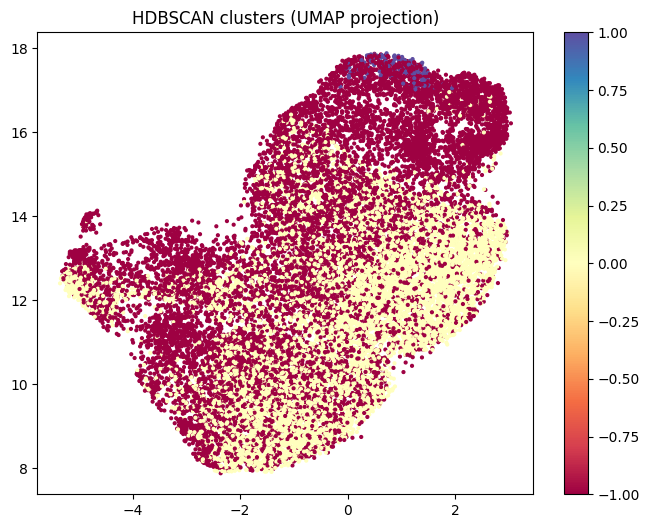

In [12]:
# Ячейка E: UMAP + визуализация
import umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_pca)

# Визуализация кластеров HDBSCAN
plt.figure(figsize=(8,6))
plt.scatter(X_umap[:,0], X_umap[:,1], c=labels_hdb, s=4, cmap='Spectral')
plt.title("HDBSCAN clusters (UMAP projection)")
plt.colorbar()
plt.show()

# Визуализация по diagnostic_class (если есть)
if 'diagnostic_class' in df_meta_sub.columns:
    plt.figure(figsize=(8,6))
    classes = df_meta_sub['diagnostic_class'].values
    # простой mapping to ints for colors
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    cls_enc = le.fit_transform(classes.astype(str))
    plt.scatter(X_umap[:,0], X_umap[:,1], c=cls_enc, s=4, cmap='tab10')
    plt.title("Diagnostic classes (UMAP projection)")
    plt.colorbar(ticks=range(len(le.classes_)))
    plt.show()


#### решено было использовать только второе отведение

/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN clusters (unique): [-1  0  1]

Cluster -1: 16349 samples
[('SR', 12525), ('NORM', 7077), ('ABQRS', 2518), ('IMI', 2011), ('ASMI', 1735), ('LVH', 1599), ('NDT', 1414), ('LAFB', 1223), ('AFIB', 1147), ('ISC_', 968)]

Cluster 0: 404 samples
[('SR', 327), ('NORM', 180), ('ABQRS', 62), ('IMI', 61), ('LVH', 50), ('ASMI', 48), ('LAFB', 35), ('ISC_', 27), ('IRBBB', 27), ('AFIB', 26)]

Cluster 1: 5046 samples
[('SR', 3896), ('NORM', 2257), ('ABQRS', 747), ('IMI', 604), ('ASMI', 574), ('LVH', 483), ('NDT', 390), ('LAFB', 365), ('AFIB', 341), ('ISC_', 277)]
Visualizing ECG 68 from cluster 0


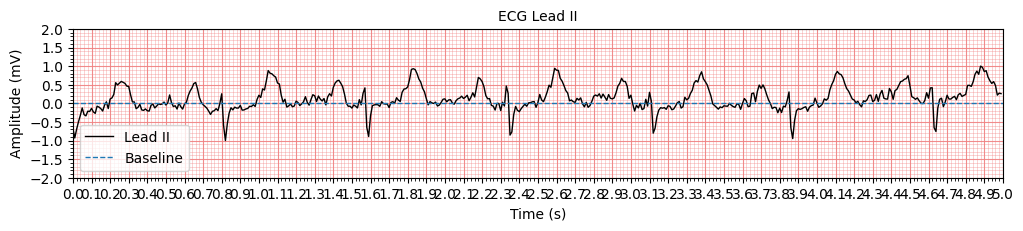

Visualizing ECG 309 from cluster 0


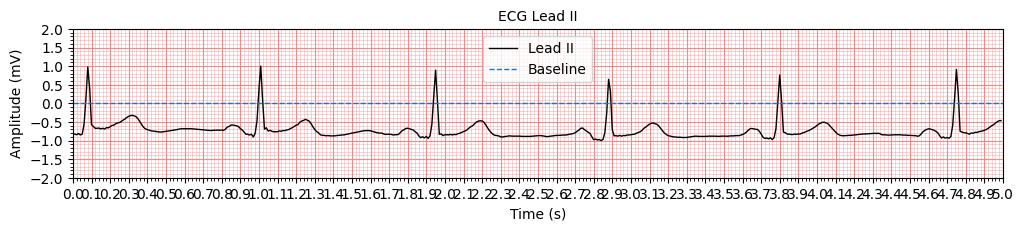

Visualizing ECG 421 from cluster 0


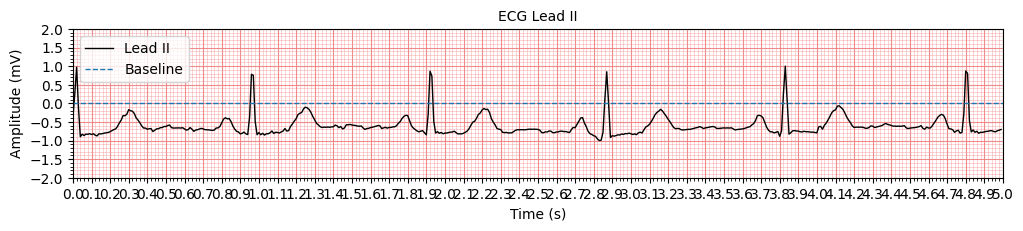

Visualizing ECG 436 from cluster 0


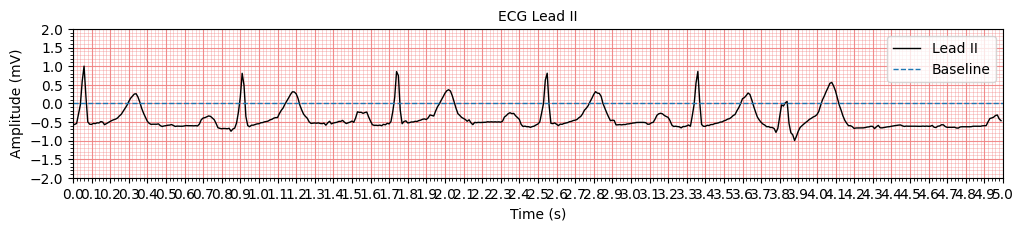

In [16]:
import numpy as np
import pandas as pd
import hdbscan
from collections import Counter
import ast
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# --- 1. Берём только эмбеддинги II отведения ---
X_lead2 = emb_all[:, 1, :]  # shape (n_samples, 768)

# --- 2. Кластеризация HDBSCAN ---
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=5, metric='euclidean')
labels_hdb = clusterer.fit_predict(X_lead2)
print("HDBSCAN clusters (unique):", np.unique(labels_hdb))

# --- 3. Создаём таблицу с кластерами и метками ---
df_clusters = pd.DataFrame({
    "ecg_id": df.index[:len(X_lead2)],
    "cluster_hdb": labels_hdb,
    "scp_codes": df["scp_codes"].values[:len(X_lead2)]
})

# Декодируем scp_codes из строк в словари
df_clusters["scp_codes"] = df_clusters["scp_codes"].apply(lambda x: list(ast.literal_eval(x).keys()))

# --- 4. Выводим распределение меток в каждом кластере ---
for cl in sorted(df_clusters["cluster_hdb"].unique()):
    subset = df_clusters[df_clusters["cluster_hdb"] == cl]
    codes = [code for sublist in subset["scp_codes"] for code in sublist]
    print(f"\nCluster {cl}: {len(subset)} samples")
    print(Counter(codes).most_common(10))

# --- 5. Функция визуализации II отведения ---
def visualize_lead(lead_result, baseline=0, fs=100, max_seconds=5):
    x = np.array(lead_result['timeline_x'])
    y = np.array(lead_result['clean_signal'])
    if max_seconds:
        max_samples = int(max_seconds * fs)
        x = x[:max_samples]
        y = y[:max_samples]
    x_tick = 0.02
    y_tick = 0.1
    fig, ax = plt.subplots(figsize=(12,3))
    ax.plot(x, y, color='black', linewidth=1.0, label="Lead II")
    ax.set_aspect(x_tick / y_tick, adjustable='box')
    ax.set_xlim(0, max_seconds)
    ax.set_ylim(-2, 2)
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick))
    ax.grid(which='minor', color='lightcoral', linewidth=0.4, alpha=0.6)
    ax.xaxis.set_major_locator(MultipleLocator(x_tick * 5))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick * 5))
    ax.grid(which='major', color='lightcoral', linewidth=0.8, alpha=0.9)
    ax.axhline(y=baseline, linestyle='--', linewidth=1, label='Baseline')
    ax.set_title("ECG Lead II", fontsize=10)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude (mV)")
    ax.legend()
    plt.show()

# --- 6. Визуализируем несколько сигналов из выбранного кластера ---
cluster_to_plot = 0  # выбери кластер для просмотра
subset = df_clusters[df_clusters["cluster_hdb"] == cluster_to_plot].head(4)

for ecg_id in subset["ecg_id"]:
    sig, meta = load_ptbxl_lr(ecg_id)
    sig_proc = preprocess_one(sig, orig_fs=int(meta['fs']), target_fs=100, duration_sec=5, band=[0.05,47])
    lead_result = {
        'timeline_x': np.arange(sig_proc.shape[1]) / 100,  # II отведение
        'clean_signal': sig_proc[1]
    }
    print(f"Visualizing ECG {ecg_id} from cluster {cluster_to_plot}")
    visualize_lead(lead_result, baseline=0, fs=100, max_seconds=5)


In [18]:
from sklearn.metrics import adjusted_rand_score

# --- 1. Топ-10 меток в каждом кластере ---
for cl in sorted(df_clusters["cluster_hdb"].unique()):
    subset = df_clusters[df_clusters["cluster_hdb"] == cl]
    codes = [code for sublist in subset["scp_codes"] for code in sublist]
    print(f"\nCluster {cl}: {len(subset)} samples")
    print("Top-10 scp_codes:", Counter(codes).most_common(10))

# --- 2. Purity ---
total_samples = len(df_clusters)
purity_sum = 0
for cl in df_clusters["cluster_hdb"].unique():
    subset = df_clusters[df_clusters["cluster_hdb"] == cl]
    if len(subset) == 0:
        continue
    codes = [code for sublist in subset["scp_codes"] for code in sublist]
    most_common_count = Counter(codes).most_common(1)[0][1]
    purity_sum += most_common_count
purity = purity_sum / total_samples
print("\nPurity:", round(purity, 4))

# --- 3. Adjusted Rand Index (если хочешь сравнить с одной меткой, например 'SR') ---
# Пример: кодируем 'SR' как 1, всё остальное как 0
true_labels = df_clusters["scp_codes"].apply(lambda x: 1 if 'SR' in x else 0).values
ari = adjusted_rand_score(true_labels, df_clusters["cluster_hdb"].replace(-1, 999))  # -1 заменили на отдельное число
print("Adjusted Rand Index (для метки SR):", round(ari, 4))





Cluster -1: 16349 samples
Top-10 scp_codes: [('SR', 12525), ('NORM', 7077), ('ABQRS', 2518), ('IMI', 2011), ('ASMI', 1735), ('LVH', 1599), ('NDT', 1414), ('LAFB', 1223), ('AFIB', 1147), ('ISC_', 968)]

Cluster 0: 404 samples
Top-10 scp_codes: [('SR', 327), ('NORM', 180), ('ABQRS', 62), ('IMI', 61), ('LVH', 50), ('ASMI', 48), ('LAFB', 35), ('ISC_', 27), ('IRBBB', 27), ('AFIB', 26)]

Cluster 1: 5046 samples
Top-10 scp_codes: [('SR', 3896), ('NORM', 2257), ('ABQRS', 747), ('IMI', 604), ('ASMI', 574), ('LVH', 483), ('NDT', 390), ('LAFB', 365), ('AFIB', 341), ('ISC_', 277)]

Purity: 0.7683
Adjusted Rand Index (для метки SR): -0.0047


Для оценки качества эмбеддингов HuBERT-ECG, построенных на II отведении сигналов PTB-XL, была выполнена кластеризация с использованием алгоритма HDBSCAN. Алгоритм автоматически выделил два плотных кластера (0 и 1) и пометил оставшиеся сигналы как шум (-1).

Cluster 0 (404 сигнала) содержит в основном синусовый ритм (SR) и нормальные сигналы (NORM), а также небольшое количество патологий.

Cluster 1 (5046 сигналов) включает больше сигналов с синусовым ритмом и нормальных, а также частично патологические сигналы.

Cluster -1 (16349 сигналов) содержит шумовые сигналы, слишком разнообразные по форме, чтобы попасть в плотный кластер.

Анализ меток scp_codes показал, что в кластерах сохраняется доминирующая метка: purity кластеров составила ~0.77, что свидетельствует о том, что большинство сигналов в кластерах имеют схожий морфологический паттерн. Adjusted Rand Index для метки SR оказался близким к нулю, что отражает наличие сигналов с этой меткой во всех кластерах и шуме — кластеризация выявляет сходство по форме, а не строго по медицинской разметке.

Визуализация отдельных сигналов из кластеров подтверждает, что эмбеддинги отражают морфологическую структуру ECG.

Вывод: кластеризация показала, что эмбеддинги HuBERT-ECG содержат информативные признаки сигналов и могут быть использованы для дальнейшей multi-label классификации паттернов ECG, как на II отведении, так и при использовании всех 12 отведений.

In [23]:
from collections import Counter

# scp_codes — словарь для каждого сигнала: {"NORM":1, "IMI":0, ...}
label_counter = Counter()
for d in df['scp_codes']:
    # если d это строка, нужно превратить в dict
    scp_dict = ast.literal_eval(d) if isinstance(d, str) else d
    # считаем только метки с likelihood > 0
    label_counter.update([k for k, v in scp_dict.items() if v > 0])

# Выводим топ меток
for label, count in label_counter.most_common():
    print(label, count)

print("Total signals:", len(df))


NORM 9514
IMI 2676
ASMI 2357
LVH 2132
NDT 1825
LAFB 1623
ISC_ 1272
IRBBB 1118
PVC 1027
1AVB 793
IVCD 787
ISCAL 659
NST_ 559
CRBBB 541
CLBBB 536
ILMI 478
LAO/LAE 426
AMI 353
ALMI 288
PACE 287
ISCIN 218
INJAS 214
LMI 201
ISCIL 179
DIG 177
LPFB 177
ISCAS 169
INJAL 145
ISCLA 140
RVH 126
LNGQT 116
ANEUR 104
RAO/RAE 99
EL 96
WPW 79
ILBBB 77
AFLT 56
IPLMI 51
AFIB 48
ISCAN 44
PAC 37
IPMI 33
SEHYP 29
PSVT 24
BIGU 24
INJIN 18
INJLA 17
PMI 17
3AVB 16
INJIL 15
2AVB 14
STACH 4
Total signals: 21799


In [27]:
import numpy as np
import glob
import os

# Папка с эмбеддингами 12 отведений
emb_dir = "/Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47"
files = sorted(glob.glob(os.path.join(emb_dir, "embeddings_*.npy")))

# Список для батчей II отведения
emb_lead2_batches = []

for f in files:
    data = np.load(f)  # shape: (batch_size, 12, 768)
    emb_lead2 = data[:, 1, :]  # берём II отведение (index=1)
    emb_lead2_batches.append(emb_lead2)

# Объединяем все батчи в один массив
X_all = np.concatenate(emb_lead2_batches, axis=0)
print("Shape of II lead embeddings:", X_all.shape)


Shape of II lead embeddings: (21799, 768)


In [42]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# --- 1. Путь к данным ---
metadata_csv = "/Users/elizaveta/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_database.csv"
embeddings_dir = "/Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47"

# --- 2. Загружаем метаданные ---
df = pd.read_csv(metadata_csv, index_col="ecg_id")

# --- 3. Задаём список меток для классификации ---
labels_keep = [
    'NORM','IMI','ASMI','LVH','NDT','LAFB','ISC_','IRBBB','PVC',
    '1AVB','IVCD','ISCAL','NST_','CRBBB','CLBBB','ILMI','LAO/LAE',
    'AMI','ALMI','PACE'
]

# --- 4. Фильтрация меток ---
def filter_labels(scp_dict_str):
    scp_dict = eval(scp_dict_str)
    filtered = [k for k,v in scp_dict.items() if k in labels_keep and float(v) > 0]
    if not filtered:
        filtered = ["Other"]
    return filtered

df['filtered_labels'] = df['scp_codes'].apply(filter_labels)
print("Пример фильтрованных меток:\n", df['filtered_labels'].head())

# --- 5. Бинаризация меток ---
mlb = MultiLabelBinarizer()
Y_all = mlb.fit_transform(df['filtered_labels'])
label_names = mlb.classes_
print("Все метки после фильтрации и бинаризации:", label_names)

# --- 6. Загружаем эмбеддинги всех 12 отведений ---
# Важно: объединяем все сохранённые батчи в один массив
all_files = sorted([os.path.join(embeddings_dir, f) for f in os.listdir(embeddings_dir) if f.endswith(".npy")])
emb_list = [np.load(f) for f in all_files]
X_all_12leads = np.concatenate(emb_list, axis=0)  # shape: (N, 12, 768)
print("X_all_12leads.shape:", X_all_12leads.shape)

# --- 7. Берём только II отведение (индекс 1) ---
X_all = X_all_12leads[:, 1, :]  # (N, 768)

# --- 8. Нормализация ---
scaler = StandardScaler()
X_all = scaler.fit_transform(X_all)

# --- 9. Разделение на train/val/test ---
train_mask = df['strat_fold'] <= 8
val_mask   = df['strat_fold'] == 9
test_mask  = df['strat_fold'] == 10

X_train, Y_train = X_all[train_mask.values], Y_all[train_mask.values]
X_val,   Y_val   = X_all[val_mask.values],   Y_all[val_mask.values]
X_test,  Y_test  = X_all[test_mask.values],  Y_all[test_mask.values]

print("Размеры train/val/test:")
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

# --- 10. Обучаем One-vs-Rest Logistic Regression ---
clf = OneVsRestClassifier(LogisticRegression(max_iter=500, n_jobs=-1))
clf.fit(X_train, Y_train)

# --- 11. Предсказание и оценка ---
Y_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_pred, target_names=label_names))


Пример фильтрованных меток:
 ecg_id
1    [NORM]
2    [NORM]
3    [NORM]
4    [NORM]
5    [NORM]
Name: filtered_labels, dtype: object
Все метки после фильтрации и бинаризации: ['1AVB' 'ALMI' 'AMI' 'ASMI' 'CLBBB' 'CRBBB' 'ILMI' 'IMI' 'IRBBB' 'ISCAL'
 'ISC_' 'IVCD' 'LAFB' 'LAO/LAE' 'LVH' 'NDT' 'NORM' 'NST_' 'Other' 'PACE'
 'PVC']
X_all_12leads.shape: (21799, 12, 768)
Размеры train/val/test:
(17418, 768) (17418, 21)
(2183, 768) (2183, 21)
(2198, 768) (2198, 21)


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_los

              precision    recall  f1-score   support

        1AVB       0.00      0.00      0.00        79
        ALMI       0.00      0.00      0.00        27
         AMI       0.00      0.00      0.00        35
        ASMI       0.00      0.00      0.00       234
       CLBBB       0.50      0.02      0.04        54
       CRBBB       0.00      0.00      0.00        54
        ILMI       0.00      0.00      0.00        48
         IMI       0.33      0.00      0.01       267
       IRBBB       0.00      0.00      0.00       112
       ISCAL       0.00      0.00      0.00        66
        ISC_       0.00      0.00      0.00       128
        IVCD       0.00      0.00      0.00        79
        LAFB       0.00      0.00      0.00       162
     LAO/LAE       0.00      0.00      0.00        42
         LVH       0.00      0.00      0.00       214
         NDT       0.00      0.00      0.00       182
        NORM       0.45      0.27      0.34       963
        NST_       0.00    

/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid 

In [44]:
import numpy as np
import os

save_dir = "/Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47"

files = sorted([f for f in os.listdir(save_dir) if f.endswith('.npy')])
X_list = []

for f in files:
    X_chunk = np.load(os.path.join(save_dir, f))
    X_list.append(X_chunk)

# объединяем все батчи в один массив
X_all_12leads = np.concatenate(X_list, axis=0)
print("X_all_12leads.shape:", X_all_12leads.shape)

# при желании можно сразу сохранить единый файл
np.save(os.path.join(save_dir, "embeddings_12leads_all.npy"), X_all_12leads)


X_all_12leads.shape: (21799, 12, 768)


In [48]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# === 1. Путь к данным PTB-XL ===
data_root = "/Users/elizaveta/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
db_csv = os.path.join(data_root, "ptbxl_database.csv")

df = pd.read_csv(db_csv, index_col="ecg_id")

# === 2. Функции фильтрации меток ===
# Выбираем только эти метки для классификации
labels_keep = ['NORM','IMI','ASMI','LVH','NDT','LAFB','ISC_','IRBBB','PVC',
               '1AVB','IVCD','ISCAL','NST_','CRBBB','CLBBB','ILMI','LAO/LAE',
               'AMI','ALMI','PACE']

def filter_labels(scp_dict):
    """Берём только нужные метки из scp_codes"""
    # scp_dict — это строка с форматом "{'NORM': 100.0, ...}"
    if isinstance(scp_dict, str):
        scp_dict = eval(scp_dict)
    filtered = [k for k, v in scp_dict.items() if k in labels_keep and v > 0]
    if not filtered:
        filtered = ['Other']  # для сигналов без нужной метки
    return filtered

df['filtered_labels'] = df['scp_codes'].apply(filter_labels)

# === 3. Загружаем эмбеддинги всех 12 отведений ===
# shape: (N, 12, 768)
embeddings_dir = "/Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47"
# Предполагается, что эмбеддинги сохранены батчами
files = sorted([f for f in os.listdir(embeddings_dir) if f.endswith(".npy")])
X_list = [np.load(os.path.join(embeddings_dir, f)) for f in files]
X_all_12leads = np.concatenate(X_list, axis=0)  # (N, 12, 768)

print("X_all_12leads.shape:", X_all_12leads.shape)

# === 4. Объединяем все 12 отведений в один вектор ===
X_all = X_all_12leads.reshape(len(X_all_12leads), -1)  # (N, 12*768=9216)

# === 5. Бинаризуем метки ===
mlb = MultiLabelBinarizer()
Y_all = mlb.fit_transform(df['filtered_labels'])
print("Все метки после фильтрации и бинаризации:", mlb.classes_)

# === 6. Создаём отображение ecg_id -> позиция в массиве ===
ecg_id_to_idx = {ecg_id: i for i, ecg_id in enumerate(df.index)}

# === 7. Разделяем на train/val/test по strat_fold ===
train_idx = [ecg_id_to_idx[i] for i in df[df['strat_fold'] <= 8].index]
val_idx   = [ecg_id_to_idx[i] for i in df[df['strat_fold'] == 9].index]
test_idx  = [ecg_id_to_idx[i] for i in df[df['strat_fold'] == 10].index]

X_train, Y_train = X_all[train_idx], Y_all[train_idx]
X_val,   Y_val   = X_all[val_idx],   Y_all[val_idx]
X_test,  Y_test  = X_all[test_idx],  Y_all[test_idx]

print("Размеры train/val/test:")
print(X_train.shape, Y_train.shape)
print(X_val.shape,   Y_val.shape)
print(X_test.shape,  Y_test.shape)

# === 8. Нормализация признаков ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# === 9. Обучаем One-vs-Rest Logistic Regression ===
clf = OneVsRestClassifier(LogisticRegression(max_iter=500, n_jobs=-1))
clf.fit(X_train, Y_train)

# === 10. Предсказания и оценка ===
Y_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_pred, target_names=mlb.classes_))


X_all_12leads.shape: (43598, 12, 768)
Все метки после фильтрации и бинаризации: ['1AVB' 'ALMI' 'AMI' 'ASMI' 'CLBBB' 'CRBBB' 'ILMI' 'IMI' 'IRBBB' 'ISCAL'
 'ISC_' 'IVCD' 'LAFB' 'LAO/LAE' 'LVH' 'NDT' 'NORM' 'NST_' 'Other' 'PACE'
 'PVC']
Размеры train/val/test:
(17418, 9216) (17418, 21)
(2183, 9216) (2183, 21)
(2198, 9216) (2198, 21)


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_lin

              precision    recall  f1-score   support

        1AVB       0.03      0.03      0.03        79
        ALMI       0.00      0.00      0.00        27
         AMI       0.00      0.00      0.00        35
        ASMI       0.09      0.11      0.10       234
       CLBBB       0.00      0.00      0.00        54
       CRBBB       0.00      0.00      0.00        54
        ILMI       0.00      0.00      0.00        48
         IMI       0.10      0.12      0.11       267
       IRBBB       0.03      0.04      0.03       112
       ISCAL       0.06      0.03      0.04        66
        ISC_       0.04      0.04      0.04       128
        IVCD       0.04      0.03      0.03        79
        LAFB       0.07      0.07      0.07       162
     LAO/LAE       0.17      0.05      0.07        42
         LVH       0.12      0.14      0.13       214
         NDT       0.10      0.13      0.11       182
        NORM       0.44      0.44      0.44       963
        NST_       0.00    

/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid 

In [53]:
# --------- полностью рабочий и устойчивый скрипт ------------
import os, glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# ----------------- Параметры (проверь пути) -----------------
DATA_ROOT = "/Users/elizaveta/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
DB_CSV = os.path.join(DATA_ROOT, "ptbxl_database.csv")
EMBED_DIR = "/Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47"
# Условие: в папке EMBED_DIR лежат файлы типа embeddings_12leads_0_200.npy, embeddings_12leads_200_400.npy, ...

USE_SUPERCLASS = True
SUPER_CLASSES = ['NORM','IMI','ASMI','LVH','NDT']  # топ-5 как суперклассы

# ----------------- 1) Загружаем метаданные ------------------
df = pd.read_csv(DB_CSV, index_col="ecg_id")
n_signals = len(df)
print("Signals in metadata (expected N):", n_signals)

# ----------------- 2) Загружаем батчи эмбеддингов ------------
files = sorted(glob.glob(os.path.join(EMBED_DIR, "embeddings_12leads_*.npy")))
if len(files) == 0:
    raise FileNotFoundError(f"No npy files found in {EMBED_DIR}. Check save folder and filenames.")

print("Found %d batch files (showing first 5):" % len(files), files[:5])
batch_list = []
total_rows = 0
for f in files:
    arr = np.load(f)
    if arr.ndim != 3 or arr.shape[1] != 12:
        raise ValueError(f"Unexpected batch shape {arr.shape} in file {f}. Expected (batch_size, 12, 768).")
    batch_list.append(arr)
    total_rows += arr.shape[0]
    print(f"Loaded {f}  shape={arr.shape}")

print("Total rows across batches:", total_rows)

# concatenate along axis=0 (rows)
X_all_12leads = np.concatenate(batch_list, axis=0)
print("Concatenated shape:", X_all_12leads.shape)

# ------------- 3) Deduplicate robustно по содержимому -------------
# Если количество строк совпадает с n_signals — ок.
# Если количество строк != n_signals — попробуем удалить дубликаты по содержимому.
if X_all_12leads.shape[0] != n_signals:
    print("Number of rows != number of metadata signals -> attempting deduplication by content...")

    # map content -> first index encountered
    seen = {}
    first_indices = []
    # We'll use .tobytes() as a fast fingerprint; it's deterministic for same array contents
    for i in range(X_all_12leads.shape[0]):
        key = X_all_12leads[i].tobytes()
        if key not in seen:
            seen[key] = i
            first_indices.append(i)

    unique_count = len(first_indices)
    print("Unique embeddings found (by content):", unique_count)

    if unique_count == n_signals:
        # build unique array in order of first occurrence
        X_unique = X_all_12leads[first_indices]
        # try to reorder unique to match metadata order if we assume batches were saved in df order
        # Usually first occurrence order equals df order; verify dimensions
        X_all_12leads = X_unique
        print("Deduplication successful: new shape", X_all_12leads.shape)
    else:
        # try alternative heuristics: maybe every signal duplicated consecutively (pairs)
        if X_all_12leads.shape[0] == 2 * n_signals:
            # check whether first half equals second half
            if np.allclose(X_all_12leads[:n_signals], X_all_12leads[n_signals:]):
                X_all_12leads = X_all_12leads[:n_signals]
                print("Detected exact first-half == second-half duplication -> kept first half.")
            else:
                # try take every second row (if duplicated alternating)
                alt = X_all_12leads[::2]
                if alt.shape[0] == n_signals:
                    print("Trying alternating dedup (take every 2nd row).")
                    X_all_12leads = alt
                else:
                    raise ValueError(
                        "Couldn't deduplicate to match metadata length. "
                        f"Found {unique_count} unique contents, total rows {X_all_12leads.shape[0]}, expected {n_signals}. "
                        "Inspect embeddings saving logic."
                    )
        else:
            raise ValueError(
                "Couldn't deduplicate to match metadata length. "
                f"Unique count {unique_count}, total rows {X_all_12leads.shape[0]}, expected {n_signals}."
            )

# Final check
if X_all_12leads.shape[0] != n_signals:
    raise ValueError("After deduplication, row count still doesn't match metadata: "
                     f"{X_all_12leads.shape[0]} vs {n_signals}. Abort.")

print("Final X_all_12leads.shape:", X_all_12leads.shape)  # must be (n_signals, 12, 768)

# ------------- 4) Формируем суперклассы -------------
def extract_superclass(scp_dict):
    if isinstance(scp_dict, str):
        scp_dict = eval(scp_dict)
    labels = [k for k,v in scp_dict.items() if float(v) > 0]
    if USE_SUPERCLASS:
        for sc in SUPER_CLASSES:
            if sc in labels:
                return [sc]
        return ['Other']
    else:
        return labels if labels else ['Other']

df['filtered_labels'] = df['scp_codes'].apply(extract_superclass)
print("Example filtered labels (first 6):")
print(df['filtered_labels'].head(6))

# ------------- 5) Convert labels -> binary matrix -------------
mlb = MultiLabelBinarizer()
Y_all = mlb.fit_transform(df['filtered_labels'])
print("Classes used:", mlb.classes_)
print("Y_all.shape:", Y_all.shape)

# ------------- 6) Prepare features: flatten 12 leads -> one vector -------------
X_all = X_all_12leads.reshape(n_signals, -1)  # (N, 12*768)
print("X_all shape after flatten:", X_all.shape)

# ------------- 7) Scale features -------------
scaler = StandardScaler()
X_all = scaler.fit_transform(X_all)

# ------------- 8) Split by strat_fold (use boolean masks) -------------
train_mask = (df['strat_fold'] <= 8).values
val_mask   = (df['strat_fold'] == 9).values
test_mask  = (df['strat_fold'] == 10).values

X_train, Y_train = X_all[train_mask], Y_all[train_mask]
X_val,   Y_val   = X_all[val_mask],   Y_all[val_mask]
X_test,  Y_test  = X_all[test_mask],  Y_all[test_mask]

print("Train/Val/Test shapes:")
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

# ------------- 9) Train a simple MLP (sklearn) -------------
mlp = MLPClassifier(hidden_layer_sizes=(1024,512),
                    activation='relu',
                    batch_size=64,
                    max_iter=60,
                    random_state=42,
                    verbose=True)

mlp.fit(X_train, Y_train)

# ------------- 10) Evaluate on test -------------
Y_pred = mlp.predict(X_test)
print("\nClassification report (test):")
print(classification_report(Y_test, Y_pred, target_names=mlb.classes_))


Signals in metadata (expected N): 21799
Found 110 batch files (showing first 5): ['/Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_0_200.npy', '/Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_10000_10200.npy', '/Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_1000_1200.npy', '/Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_10200_10400.npy', '/Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_10400_10600.npy']
Loaded /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_0_200.npy  shape=(200, 12, 768)
Loaded /Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47/embeddings_12leads_10000_10200.npy  shape=(200, 12, 768)
Loaded /Users/elizaveta/vs project/jupyter project/emb

/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Iteration 1, loss = 2.68769904
Iteration 2, loss = 2.38822040
Iteration 3, loss = 2.36969236
Iteration 4, loss = 2.33490613
Iteration 5, loss = 2.30357498
Iteration 6, loss = 2.25536727
Iteration 7, loss = 2.18750560
Iteration 8, loss = 2.11546754
Iteration 9, loss = 2.02139655
Iteration 10, loss = 1.92760254
Iteration 11, loss = 1.83449266
Iteration 12, loss = 1.72905555
Iteration 13, loss = 1.65643655
Iteration 14, loss = 1.54395836
Iteration 15, loss = 1.49456390
Iteration 16, loss = 1.41780483
Iteration 17, loss = 1.37636418
Iteration 18, loss = 1.31244383
Iteration 19, loss = 1.29530175
Iteration 20, loss = 1.26038320
Iteration 21, loss = 1.14085212
Iteration 22, loss = 1.13227162
Iteration 23, loss = 1.10501668
Iteration 24, loss = 1.08695131
Iteration 25, loss = 1.04069736
Iteration 26, loss = 1.04846405
Iteration 27, loss = 1.00053905
Iteration 28, loss = 0.96990378
Iteration 29, loss = 0.95900396
Iteration 30, loss = 0.97479721
Iteration 31, loss = 0.90888015
Iteration 32, los

/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no pre

Classification report (test):
              precision    recall  f1-score   support

        ASMI       0.07      0.01      0.02       179
         IMI       0.12      0.03      0.05       267
         LVH       0.16      0.02      0.03       157
         NDT       0.07      0.01      0.02       160
        NORM       0.45      0.40      0.43       963
       Other       0.23      0.15      0.18       472

   micro avg       0.36      0.22      0.27      2198
   macro avg       0.18      0.11      0.12      2198
weighted avg       0.28      0.22      0.24      2198
 samples avg       0.21      0.22      0.22      2198


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


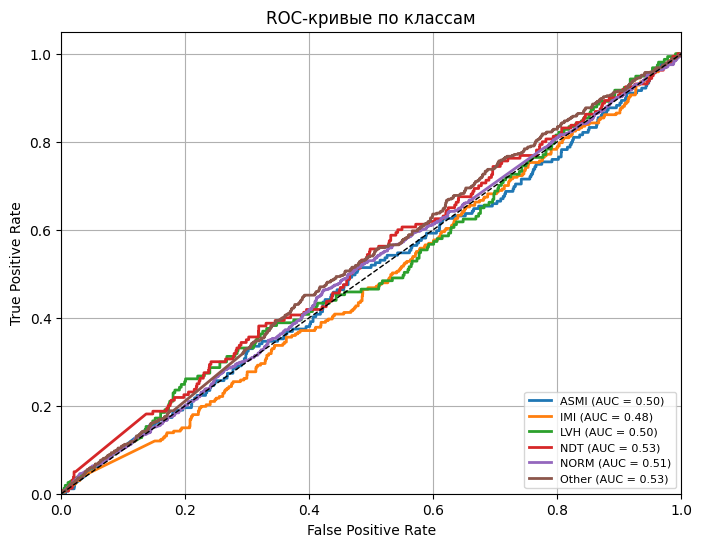

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# --- Построим ROC-кривые для каждого класса ---
# бинаризуем истинные метки и предсказания
Y_test_bin = np.array(Y_test)
Y_pred_proba = mlp.predict_proba(X_test)

# Если predict_proba вернул список (по одному массиву на класс) — склеим его
if isinstance(Y_pred_proba, list):
    Y_pred_proba = np.stack([p[:, 1] for p in Y_pred_proba], axis=1)

n_classes = Y_test_bin.shape[1]
class_names = mlb.classes_

# --- Рисуем ROC-кривые ---
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(Y_test_bin[:, i], Y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые по классам')
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.show()


In [56]:
# ----- imports -----
import os, glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter

# ====== 1. Параметры (проверь пути) ======
DATA_ROOT = "/Users/elizaveta/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
DB_CSV = os.path.join(DATA_ROOT, "ptbxl_database.csv")
EMBED_DIR = "/Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47"

USE_SUPERCLASS = True
SUPER_CLASSES = ['NORM','IMI','ASMI','LVH','NDT']   # если хочешь другие — поменяй

# ====== 2. Загрузка метаданных ======
df = pd.read_csv(DB_CSV, index_col="ecg_id")
N = len(df)
print("N metadata =", N)

# ====== 3. Формирование целевой метки (single-label multiclass) ======
def one_superclass_label(scp_str):
    scp = eval(scp_str) if isinstance(scp_str, str) else scp_str
    present = [k for k,v in scp.items() if float(v) > 0]
    if USE_SUPERCLASS:
        for s in SUPER_CLASSES:
            if s in present:
                return s
        return "Other"
    else:
        # fallback - choose first present label (not recommended for many labels)
        return present[0] if present else "Other"

df["target_label"] = df["scp_codes"].apply(one_superclass_label)
print(df["target_label"].value_counts())

# ====== 4. Загрузка эмбеддингов (корректно concat/concatenate уже сделанных батчей) ======
# ожидается, что после исправлений у тебя есть правильные батчи, которые конкатенировать по axis=0 даёт (N,12,768)
# --- загрузка эмбеддингов ---
files = sorted(glob.glob(os.path.join(EMBED_DIR, "embeddings_12leads_*.npy")))
X_list = [np.load(f) for f in files]
X_all_12leads = np.concatenate(X_list, axis=0)
print("Raw concatenated embeddings shape:", X_all_12leads.shape)

# --- проверка и исправление количества записей ---
N = len(df)
if X_all_12leads.shape[0] > N:
    print(f"Внимание: эмбеддингов {X_all_12leads.shape[0]}, метаданных {N}. Обрезаем до {N}.")
    X_all_12leads = X_all_12leads[:N]
elif X_all_12leads.shape[0] < N:
    raise RuntimeError(f"Эмбеддингов меньше, чем записей ({X_all_12leads.shape[0]} < {N}). Проверь загрузку.")
else:
    print("Количество эмбеддингов совпадает с метаданными.")

print("X_all_12leads.shape:", X_all_12leads.shape)


# ====== 5. Препроцессинг признаков ======
# flatten 12 leads -> single vector
X = X_all_12leads.reshape(N, -1)   # (N, 9216)
print("Flatten shape:", X.shape)

# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

# PCA (рекомендую) — уменьшает размерность, стабилизирует обучение
pca_components = 512   # попробуй 512 или 1024
from sklearn.decomposition import PCA
pca = PCA(n_components=pca_components, random_state=42)
X_pca = pca.fit_transform(X)
print("After PCA:", X_pca.shape)

# ====== 6. Label encoding и class weights ======
le = LabelEncoder()
y = le.fit_transform(df["target_label"].values)
class_names = le.classes_
print("Classes:", class_names)

# class weights (inverse freq)
counts = Counter(y)
print("Counts per class:", counts)
# weight per class = total / (num_classes * count)
total = len(y)
num_classes = len(class_names)
class_weight = {i: total/(num_classes * counts[i]) for i in range(num_classes)}
print("Class weight map:", class_weight)

# ====== 7. Split by strat_fold (PTB-XL recommendation) ======
train_mask = (df['strat_fold'] <= 8).values
val_mask   = (df['strat_fold'] == 9).values
test_mask  = (df['strat_fold'] == 10).values

X_train, y_train = X_pca[train_mask], y[train_mask]
X_val,   y_val   = X_pca[val_mask],   y[val_mask]
X_test,  y_test  = X_pca[test_mask],  y[test_mask]

print("Shapes train/val/test:", X_train.shape, X_val.shape, X_test.shape)

# ====== 8. PyTorch Dataset / Dataloader ======
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

batch_size = 64
train_loader = DataLoader(TabularDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TabularDataset(X_val,   y_val),   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TabularDataset(X_test,  y_test),  batch_size=batch_size, shuffle=False)

# ====== 9. MLP model (PyTorch) ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

class MLP(nn.Module):
    def __init__(self, input_dim, n_classes, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, n_classes)
        )
    def forward(self,x):
        return self.net(x)

model = MLP(input_dim=pca_components, n_classes=num_classes).to(device)

# Loss with class weights
weights = torch.tensor([class_weight[i] for i in range(num_classes)], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ====== 10. Training loop ======
num_epochs = 30
best_val_loss = 1e9
for epoch in range(1, num_epochs+1):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch}/{num_epochs}  train_loss={train_loss:.4f}  val_loss={val_loss:.4f}")

# ====== 11. Evaluation ======
model.eval()
all_preds = []
all_probs = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

y_pred = np.concatenate(all_preds)
y_proba = np.concatenate(all_probs)

print("Classification report (test):")
print(classification_report(y_test, y_pred, target_names=class_names))
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)


N metadata = 21799
target_label
NORM     9514
Other    4674
IMI      2675
ASMI     1769
NDT      1588
LVH      1579
Name: count, dtype: int64
Raw concatenated embeddings shape: (43598, 12, 768)
Внимание: эмбеддингов 43598, метаданных 21799. Обрезаем до 21799.
X_all_12leads.shape: (21799, 12, 768)
Flatten shape: (21799, 9216)


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13

After PCA: (21799, 512)
Classes: ['ASMI' 'IMI' 'LVH' 'NDT' 'NORM' 'Other']
Counts per class: Counter({np.int64(4): 9514, np.int64(5): 4674, np.int64(1): 2675, np.int64(0): 1769, np.int64(3): 1588, np.int64(2): 1579})
Class weight map: {0: 2.0537968720557753, 1: 1.3581931464174455, 2: 2.300928857926958, 3: 2.2878883291351806, 4: 0.38187583210707027, 5: 0.7773142205106262}
Shapes train/val/test: (17418, 512) (2183, 512) (2198, 512)
Device: cpu
Epoch 1/30  train_loss=1.8190  val_loss=1.7994
Epoch 2/30  train_loss=1.7793  val_loss=1.8087
Epoch 3/30  train_loss=1.7508  val_loss=1.8238
Epoch 4/30  train_loss=1.6898  val_loss=1.8684
Epoch 5/30  train_loss=1.6295  val_loss=1.9134
Epoch 6/30  train_loss=1.5335  val_loss=1.9553
Epoch 7/30  train_loss=1.4408  val_loss=1.9845
Epoch 8/30  train_loss=1.3487  val_loss=2.1266
Epoch 9/30  train_loss=1.2697  val_loss=2.1124
Epoch 10/30  train_loss=1.2027  val_loss=2.2510
Epoch 11/30  train_loss=1.1456  val_loss=2.2239
Epoch 12/30  train_loss=1.0898  val

Classes after filtering:
 label
NORM    9514
IMI     2380
ASMI    2063
NDT     1630
LVH     1538
Name: count, dtype: int64
Loaded embeddings shape: (43598, 12, 768)
Flattened embeddings shape: (17125, 9216)


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13

After PCA: (17125, 256)
Classes: ['ASMI' 'IMI' 'LVH' 'NDT' 'NORM']
Shapes: (13700, 256) (1712, 256) (1713, 256)
Epoch 01: train_loss=1.6665, val_loss=1.6187
Epoch 02: train_loss=1.5978, val_loss=1.6243
Epoch 03: train_loss=1.5720, val_loss=1.6284
Epoch 04: train_loss=1.5422, val_loss=1.6525
Epoch 05: train_loss=1.5031, val_loss=1.6717
Epoch 06: train_loss=1.4743, val_loss=1.6889
Early stopping triggered!

Classification report (test):
              precision    recall  f1-score   support

        ASMI       0.10      0.14      0.12       207
         IMI       0.13      0.34      0.19       238
         LVH       0.10      0.18      0.12       153
         NDT       0.08      0.12      0.10       163
        NORM       0.57      0.17      0.26       952

    accuracy                           0.18      1713
   macro avg       0.19      0.19      0.16      1713
weighted avg       0.36      0.18      0.20      1713


Confusion matrix:
 [[ 29  74  30  30  44]
 [ 46  81  45  36  30]
 [ 27 

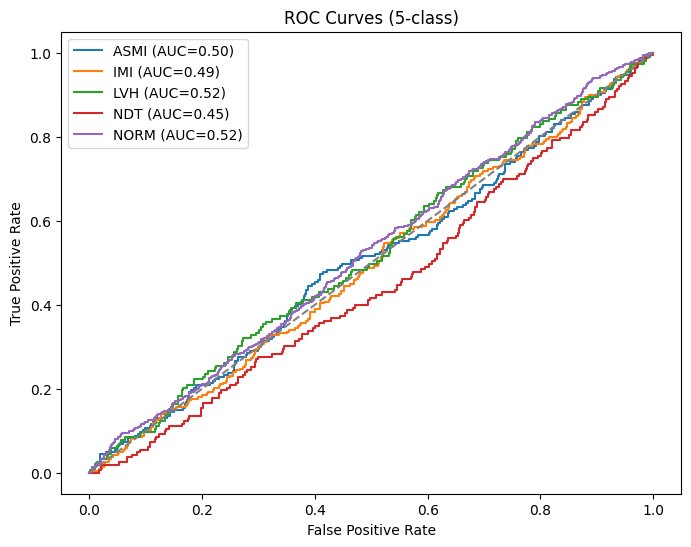

In [63]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ==========================
# 1. Загрузка метаданных
# ==========================
meta_path = "/Users/elizaveta/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_database.csv"
df = pd.read_csv(meta_path)

# Предполагаем, что scp_codes хранит JSON-подобные строки
df['scp_codes'] = df['scp_codes'].apply(eval)

# ==========================
# 2. Суперклассы
# ==========================
SUPER_CLASSES = ['NORM', 'IMI', 'ASMI', 'LVH', 'NDT']

def map_superclass(codes):
    for key in codes.keys():
        if key in SUPER_CLASSES:
            return key
    return None

df['label'] = df['scp_codes'].apply(map_superclass)
df = df.dropna(subset=['label']).reset_index(drop=True)
print("Classes after filtering:\n", df['label'].value_counts())

# ==========================
# 3. Загрузка эмбеддингов 12 отведений
# ==========================
emb_folder = "/Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47"
files = sorted([f for f in os.listdir(emb_folder) if f.endswith(".npy")])

X_list = []
for f in files:
    arr = np.load(os.path.join(emb_folder, f))
    X_list.append(arr)

X_all_12leads = np.concatenate(X_list, axis=0)
print("Loaded embeddings shape:", X_all_12leads.shape)  # должно быть (N_signals, 12, 768)

N_signals = len(df)
if X_all_12leads.shape[0] != N_signals:
    # Если количество эмбеддингов удвоено или больше, берем только первые N_signals
    X_all_12leads = X_all_12leads[:N_signals]

# Flatten 12 отведений в один вектор
X_all_flat = X_all_12leads.reshape(N_signals, -1)
print("Flattened embeddings shape:", X_all_flat.shape)  # (N_signals, 12*768)

# ==========================
# 4. Препроцессинг
# ==========================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all_flat)

pca = PCA(n_components=256, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("After PCA:", X_pca.shape)

# Метки
le = LabelEncoder()
y = le.fit_transform(df['label'])
classes = le.classes_
print("Classes:", classes)

# Train / Val / Test split
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp
)
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

# ==========================
# 5. Torch Dataset
# ==========================
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = ECGDataset(X_train, y_train)
val_ds = ECGDataset(X_val, y_val)
test_ds = ECGDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64)
test_dl = DataLoader(test_ds, batch_size=64)

# ==========================
# 6. Модель MLP
# ==========================
class ImprovedMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedMLP(256, len(classes)).to(device)

# ==========================
# 7. Обучение
# ==========================
# Class weights
class_counts = Counter(y_train)
weights = torch.tensor([len(y_train)/class_counts[i] for i in range(len(classes))], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_val_loss = float('inf')
patience, patience_counter = 5, 0

for epoch in range(30):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item()

    print(f"Epoch {epoch+1:02d}: train_loss={total_loss/len(train_dl):.4f}, val_loss={val_loss/len(val_dl):.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

# ==========================
# 8. Оценка
# ==========================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        preds = model(xb)
        y_score.append(F.softmax(preds, dim=1).cpu().numpy())
        y_pred.append(torch.argmax(preds, dim=1).cpu().numpy())
        y_true.append(yb.numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_score = np.concatenate(y_score)

print("\nClassification report (test):")
print(classification_report(y_true, y_pred, target_names=classes))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix:\n", cm)

# ==========================
# 9. ROC-кривые
# ==========================
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_true, classes=range(len(classes)))

plt.figure(figsize=(8,6))
for i, label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (5-class)")
plt.legend()
plt.show()


Classes after filtering:
label
IMI     2381
ASMI    2063
NDT     1631
LVH     1539
Name: count, dtype: int64
Loaded embeddings shape: (43598, 12, 768)


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13

After PCA: (7614, 256)
Classes: ['ASMI' 'IMI' 'LVH' 'NDT']
Shapes: (6091, 256) (761, 256) (762, 256)
Epoch 01: train_loss=1.4413, val_loss=1.4192
Epoch 02: train_loss=1.3667, val_loss=1.4123
Epoch 03: train_loss=1.3417, val_loss=1.4330
Epoch 04: train_loss=1.3054, val_loss=1.4587
Epoch 05: train_loss=1.2605, val_loss=1.4773
Epoch 06: train_loss=1.2227, val_loss=1.5203
Epoch 07: train_loss=1.1658, val_loss=1.5537
Early stopping triggered!

Classification report (test):
              precision    recall  f1-score   support

        ASMI       0.28      0.18      0.22       207
         IMI       0.37      0.40      0.39       238
         LVH       0.19      0.25      0.22       154
         NDT       0.21      0.21      0.21       163

    accuracy                           0.27       762
   macro avg       0.26      0.26      0.26       762
weighted avg       0.27      0.27      0.27       762


Confusion matrix:
 [[38 64 64 41]
 [34 96 55 53]
 [32 48 39 35]
 [32 51 46 34]]


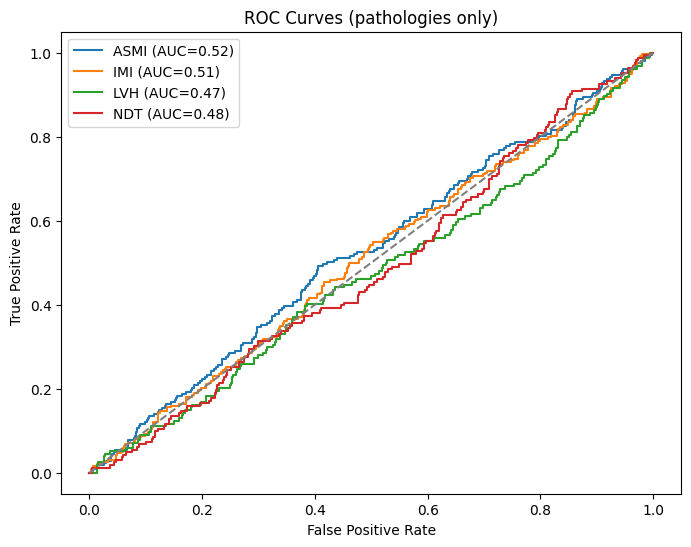

In [66]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ==========================
# 1. Загрузка метаданных PTB-XL
# ==========================
df = pd.read_csv("/Users/elizaveta/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_database.csv")
df['scp_codes'] = df['scp_codes'].apply(eval)

# --------------------------
# 1a. Фильтруем патологические классы (без NORM)
# --------------------------
SUPER_CLASSES = ['IMI', 'ASMI', 'LVH', 'NDT', 'Other']  # оставляем важные патологии + Other
def map_superclass(codes):
    keys = list(codes.keys())
    for key in keys:
        if key in SUPER_CLASSES:
            return key
    return None

df['label'] = df['scp_codes'].apply(map_superclass)
df = df.dropna(subset=['label']).reset_index(drop=True)
print("Classes after filtering:")
print(df['label'].value_counts())

# ==========================
# 2. Загрузка всех эмбеддингов 12 отведений
# ==========================
emb_folder = "/Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47"
files = sorted([f for f in os.listdir(emb_folder) if f.endswith(".npy")])

all_embeddings = []
for f in files:
    chunk = np.load(os.path.join(emb_folder, f))  # (batch_size, 12, 768)
    all_embeddings.append(chunk)

# объединяем все батчи
X_all_12leads = np.concatenate(all_embeddings, axis=0)
print("Loaded embeddings shape:", X_all_12leads.shape)

# --------------------------
# 2a. Проверка соответствия сигналам
# --------------------------
N_signals = len(df)
if X_all_12leads.shape[0] < N_signals:
    raise RuntimeError(f"Недостаточно эмбеддингов: {X_all_12leads.shape[0]} < {N_signals}")
elif X_all_12leads.shape[0] > N_signals:
    X_all_12leads = X_all_12leads[:N_signals]  # обрезаем лишние

# ==========================
# 3. Flatten 12 отведений + масштабирование + PCA
# ==========================
X_flat = X_all_12leads.reshape(N_signals, 12*768)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

pca = PCA(n_components=256, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("After PCA:", X_pca.shape)

# ==========================
# 4. Метки и split
# ==========================
le = LabelEncoder()
y = le.fit_transform(df['label'])
classes = le.classes_
print("Classes:", classes)

X_train, X_tmp, y_train, y_tmp = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp)
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

# ==========================
# 5. PyTorch Dataset
# ==========================
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = ECGDataset(X_train, y_train)
val_ds = ECGDataset(X_val, y_val)
test_ds = ECGDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64)
test_dl = DataLoader(test_ds, batch_size=64)

# ==========================
# 6. MLP модель
# ==========================
class ImprovedMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedMLP(256, len(classes)).to(device)

# ==========================
# 7. Обучение
# ==========================
# class weights
class_counts = Counter(y_train)
weights = torch.tensor([len(y_train)/class_counts[i] for i in range(len(classes))], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_val_loss = float('inf')
patience, patience_counter = 5, 0
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item()

    print(f"Epoch {epoch+1:02d}: train_loss={total_loss/len(train_dl):.4f}, val_loss={val_loss/len(val_dl):.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

# ==========================
# 8. Оценка
# ==========================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        preds = model(xb)
        y_score.append(F.softmax(preds, dim=1).cpu().numpy())
        y_pred.append(torch.argmax(preds, dim=1).cpu().numpy())
        y_true.append(yb.numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_score = np.concatenate(y_score)

print("\nClassification report (test):")
print(classification_report(y_true, y_pred, target_names=classes))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix:\n", cm)

# ==========================
# 9. ROC-кривые
# ==========================
y_true_bin = label_binarize(y_true, classes=range(len(classes)))

plt.figure(figsize=(8,6))
for i, label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (pathologies only)")
plt.legend()
plt.show()


Classes after filtering:
label
IMI     2381
ASMI    2063
NDT     1631
LVH     1539
Name: count, dtype: int64
Loaded embeddings shape: (43598, 12, 768)
II lead embeddings shape: (7614, 1, 768)
Classes: ['ASMI' 'IMI' 'LVH' 'NDT']
Shapes train/val/test: (6093, 1, 768) (758, 1, 768) (763, 1, 768)
Epoch 01: train_loss=1.3907, val_loss=1.3921
Epoch 02: train_loss=1.3881, val_loss=1.3979
Epoch 03: train_loss=1.3877, val_loss=1.3969
Epoch 04: train_loss=1.3880, val_loss=1.3886
Epoch 05: train_loss=1.3884, val_loss=1.3873
Epoch 06: train_loss=1.3878, val_loss=1.3925
Epoch 07: train_loss=1.3881, val_loss=1.3862
Epoch 08: train_loss=1.3871, val_loss=1.3954
Epoch 09: train_loss=1.3879, val_loss=1.3964
Epoch 10: train_loss=1.3891, val_loss=1.3871
Epoch 11: train_loss=1.3878, val_loss=1.3911
Epoch 12: train_loss=1.3863, val_loss=1.3915
Early stopping triggered!

Classification report (test):
              precision    recall  f1-score   support

        ASMI       0.26      0.56      0.36       204


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavio

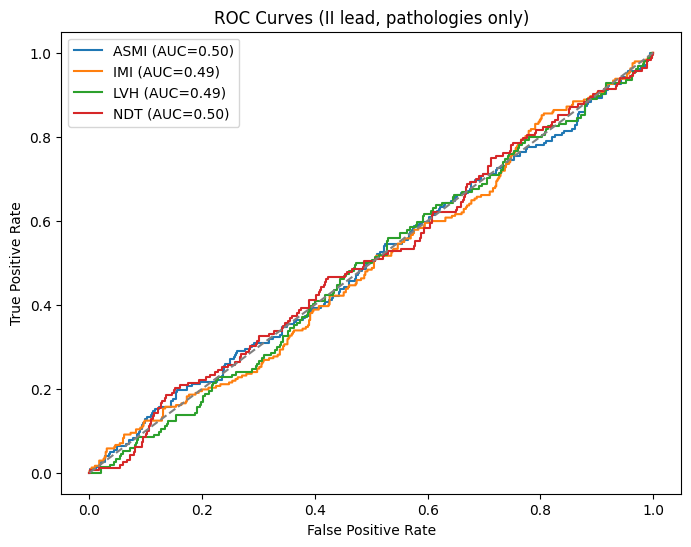

In [74]:
# ==========================
# CNN на II lead (локально)
# ==========================
import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ==========================
# 1. Пути к данным (локально)
# ==========================
dataset_folder = "/Users/elizaveta/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
emb_folder = "/Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47"

# ==========================
# 2. Загружаем метаданные PTB-XL
# ==========================
df = pd.read_csv(os.path.join(dataset_folder, "ptbxl_database.csv"))
df['scp_codes'] = df['scp_codes'].apply(eval)

# --------------------------
# Фильтруем патологические классы (без NORM)
# --------------------------
SUPER_CLASSES = ['IMI', 'ASMI', 'LVH', 'NDT']
def map_superclass(codes):
    for key in codes.keys():
        if key in SUPER_CLASSES:
            return key
    return None

df['label'] = df['scp_codes'].apply(map_superclass)
df = df.dropna(subset=['label']).reset_index(drop=True)
print("Classes after filtering:")
print(df['label'].value_counts())

# ==========================
# 3. Загружаем эмбеддинги
# ==========================
files = sorted([f for f in os.listdir(emb_folder) if f.endswith(".npy")])
all_embeddings = []
for f in files:
    chunk = np.load(os.path.join(emb_folder, f))  # shape: (batch, 12, 768)
    all_embeddings.append(chunk)

X_all_12leads_full = np.concatenate(all_embeddings, axis=0)
print("Loaded embeddings shape:", X_all_12leads_full.shape)

# --------------------------
# Выбираем фильтрованные сигналы
# --------------------------
filtered_idx = df.index.tolist()
X_all_12leads = X_all_12leads_full[filtered_idx]

# --------------------------
# Выбираем только второе отведение (II lead)
# --------------------------
X_II_lead = X_all_12leads[:, 1:2, :]  # (N_signals, 1, 768)
print("II lead embeddings shape:", X_II_lead.shape)

# ==========================
# 4. Метки
# ==========================
le = LabelEncoder()
y_all = le.fit_transform(df['label'])
classes = le.classes_
print("Classes:", classes)

# ==========================
# 5. Train / Val / Test split
# ==========================
train_idx = df[df['strat_fold'].isin(range(1,9))].index
val_idx   = df[df['strat_fold'] == 9].index
test_idx  = df[df['strat_fold'] == 10].index

X_train, y_train = X_II_lead[train_idx], y_all[train_idx]
X_val,   y_val   = X_II_lead[val_idx], y_all[val_idx]
X_test,  y_test  = X_II_lead[test_idx], y_all[test_idx]

print("Shapes train/val/test:", X_train.shape, X_val.shape, X_test.shape)

# ==========================
# 6. PyTorch Dataset
# ==========================
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = ECGDataset(X_train, y_train)
val_ds   = ECGDataset(X_val, y_val)
test_ds  = ECGDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=32)
test_dl  = DataLoader(test_ds, batch_size=32)

# ==========================
# 7. CNN на II lead embeddings
# ==========================
class CNN1Lead(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN1Lead(len(classes)).to(device)

# ==========================
# 8. Обучение
# ==========================
class_counts = Counter(y_train)
weights = torch.tensor([len(y_train)/class_counts[i] for i in range(len(classes))], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_val_loss = float('inf')
patience, patience_counter = 5, 0
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item()

    print(f"Epoch {epoch+1:02d}: train_loss={total_loss/len(train_dl):.4f}, val_loss={val_loss/len(val_dl):.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_cnn1lead.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

# ==========================
# 9. Оценка
# ==========================
model.load_state_dict(torch.load("best_cnn1lead.pt"))
model.eval()

y_true, y_pred, y_score = [], [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_score.append(F.softmax(preds, dim=1).cpu().numpy())
        y_pred.append(torch.argmax(preds, dim=1).cpu().numpy())
        y_true.append(yb.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_score = np.concatenate(y_score)

print("\nClassification report (test):")
print(classification_report(y_true, y_pred, target_names=classes))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix:\n", cm)

# ==========================
# 10. ROC-кривые
# ==========================
y_true_bin = label_binarize(y_true, classes=range(len(classes)))
plt.figure(figsize=(8,6))
for i, label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (II lead, pathologies only)")
plt.legend()
plt.show()


In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Тот же класс модели, который ты использовала
class CNN1Lead(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Загружаем модель
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN1Lead(num_classes=4).to(device)  # 4 — у тебя классы: ASMI, IMI, LVH, NDT
model.load_state_dict(torch.load("best_cnn1lead.pt", map_location=device))
model.eval()

# Теперь модель готова для прогнозов


CNN1Lead(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

Classes after filtering:
 label
NORM    9514
IMI     2380
ASMI    2063
NDT     1630
LVH     1538
Name: count, dtype: int64
Loaded embeddings shape: (43598, 12, 768)
Flattened embeddings shape: (17125, 9216)


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13

After PCA: (17125, 256)
Classes: ['ASMI' 'IMI' 'LVH' 'NDT' 'NORM']
Shapes: (13700, 256) (1712, 256) (1713, 256)
Epoch 01: train_loss=1.6595, val_loss=1.6206
Epoch 02: train_loss=1.5994, val_loss=1.6250
Epoch 03: train_loss=1.5691, val_loss=1.6341
Epoch 04: train_loss=1.5438, val_loss=1.6475
Epoch 05: train_loss=1.5084, val_loss=1.6827
Epoch 06: train_loss=1.4679, val_loss=1.7024
Early stopping triggered!

Classification report (test):
              precision    recall  f1-score   support

        ASMI       0.14      0.06      0.08       207
         IMI       0.14      0.21      0.17       238
         LVH       0.11      0.21      0.14       153
         NDT       0.11      0.17      0.13       163
        NORM       0.58      0.42      0.49       952

    accuracy                           0.31      1713
   macro avg       0.21      0.22      0.20      1713
weighted avg       0.38      0.31      0.33      1713


Confusion matrix:
 [[ 12  49  33  31  82]
 [  8  51  51  39  89]
 [  7 

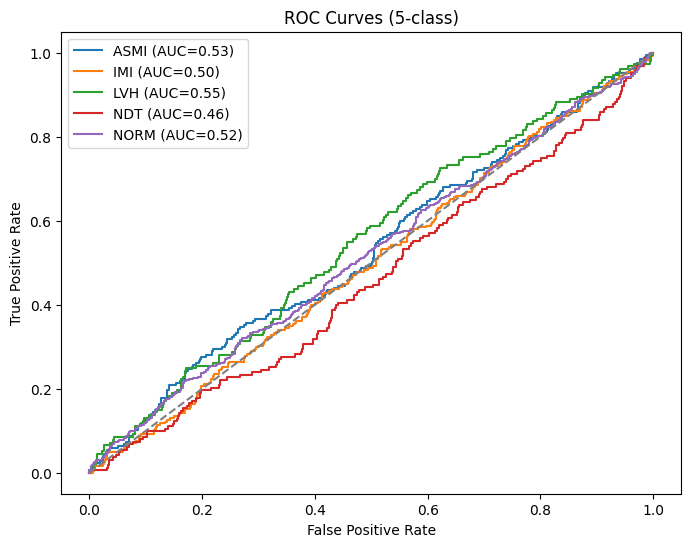

In [76]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ==========================
# 1. Загрузка метаданных
# ==========================
meta_path = "/Users/elizaveta/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_database.csv"
df = pd.read_csv(meta_path)

# Предполагаем, что scp_codes хранит JSON-подобные строки
df['scp_codes'] = df['scp_codes'].apply(eval)

# ==========================
# 2. Суперклассы
# ==========================
SUPER_CLASSES = ['NORM', 'IMI', 'ASMI', 'LVH', 'NDT']

def map_superclass(codes):
    for key in codes.keys():
        if key in SUPER_CLASSES:
            return key
    return None

df['label'] = df['scp_codes'].apply(map_superclass)
df = df.dropna(subset=['label']).reset_index(drop=True)
print("Classes after filtering:\n", df['label'].value_counts())

# ==========================
# 3. Загрузка эмбеддингов 12 отведений
# ==========================
emb_folder = "/Users/elizaveta/vs project/jupyter project/embeddings_12leads_filtered_0.05_47"
files = sorted([f for f in os.listdir(emb_folder) if f.endswith(".npy")])

X_list = []
for f in files:
    arr = np.load(os.path.join(emb_folder, f))
    X_list.append(arr)

X_all_12leads = np.concatenate(X_list, axis=0)
print("Loaded embeddings shape:", X_all_12leads.shape)  # должно быть (N_signals, 12, 768)

N_signals = len(df)
if X_all_12leads.shape[0] != N_signals:
    # Если количество эмбеддингов удвоено или больше, берем только первые N_signals
    X_all_12leads = X_all_12leads[:N_signals]

# Flatten 12 отведений в один вектор
X_all_flat = X_all_12leads.reshape(N_signals, -1)
print("Flattened embeddings shape:", X_all_flat.shape)  # (N_signals, 12*768)

# ==========================
# 4. Препроцессинг
# ==========================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all_flat)

pca = PCA(n_components=256, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("After PCA:", X_pca.shape)

# Метки
le = LabelEncoder()
y = le.fit_transform(df['label'])
classes = le.classes_
print("Classes:", classes)

# Train / Val / Test split
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp
)
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

# ==========================
# 5. Torch Dataset
# ==========================
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = ECGDataset(X_train, y_train)
val_ds = ECGDataset(X_val, y_val)
test_ds = ECGDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64)
test_dl = DataLoader(test_ds, batch_size=64)

# ==========================
# 6. Модель MLP
# ==========================
class ImprovedMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedMLP(256, len(classes)).to(device)

# ==========================
# 7. Обучение
# ==========================
# Class weights
class_counts = Counter(y_train)
weights = torch.tensor([len(y_train)/class_counts[i] for i in range(len(classes))], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_val_loss = float('inf')
patience, patience_counter = 5, 0

for epoch in range(30):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item()

    print(f"Epoch {epoch+1:02d}: train_loss={total_loss/len(train_dl):.4f}, val_loss={val_loss/len(val_dl):.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

# ==========================
# 8. Оценка
# ==========================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        preds = model(xb)
        y_score.append(F.softmax(preds, dim=1).cpu().numpy())
        y_pred.append(torch.argmax(preds, dim=1).cpu().numpy())
        y_true.append(yb.numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_score = np.concatenate(y_score)

print("\nClassification report (test):")
print(classification_report(y_true, y_pred, target_names=classes))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix:\n", cm)

# ==========================
# 9. ROC-кривые
# ==========================
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_true, classes=range(len(classes)))

plt.figure(figsize=(8,6))
for i, label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (5-class)")
plt.legend()
plt.show()


In [77]:
import joblib

# Сохраняем scaler и PCA на диск
joblib.dump(scaler, "scaler.pkl")
joblib.dump(pca, "pca.pkl")


['pca.pkl']